# Working with Albumentation

## Prerequisites

The following code expects that matplotlib and albumentation are installed on your system.
Please execute the following commands to install them.

```
!conda install -c conda-forge matplotlib albumentations
```
or
```
!pip install matplotlib albumentations
```

In [1]:
#!conda install -c conda-forge matplotlib albumentations

# or

#!pip install matplotlib albumentations

## Reading image

In [2]:
INPUT_PATH = 'input/image2.tif'

In [3]:
from cucim import CuImage

img = CuImage(INPUT_PATH)

In [4]:
try:
    import matplotlib
except ImportError:
    raise ImportError("This example requires 'matplotlib' library")

In [5]:
from matplotlib import pyplot as plt
def visualize(image):
    dpi = 80.0
    height, width, _ = image.shape
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.axis('off')
    plt.imshow(image)

[92344, 81017]


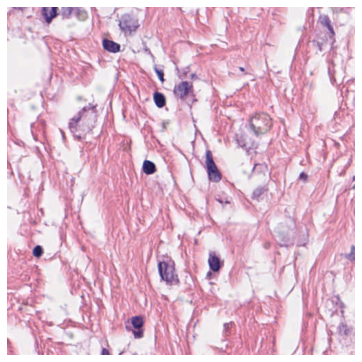

In [6]:
from PIL import Image
import numpy as np
# Read whole slide at the lowest redsolution
resolutions = img.resolutions
level_count = resolutions["level_count"]
print(img.size('XY'))
region = img.read_region(location=[50000, 40000], size=(512, 512), level=0)

#Image.fromarray(np.asarray(region))
visualize(region)

## Using Cupy

CuImage object can be converted into Cupy array.

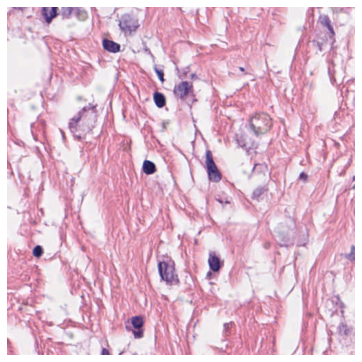

In [7]:
import cupy as cp

img = CuImage(INPUT_PATH)
region = np.asarray(img.read_region((50000, 40000), (512, 512)))
visualize(cp.asarray(region).get())

### Stain separation with cuCIM's `scikit-image`-compatible filter API

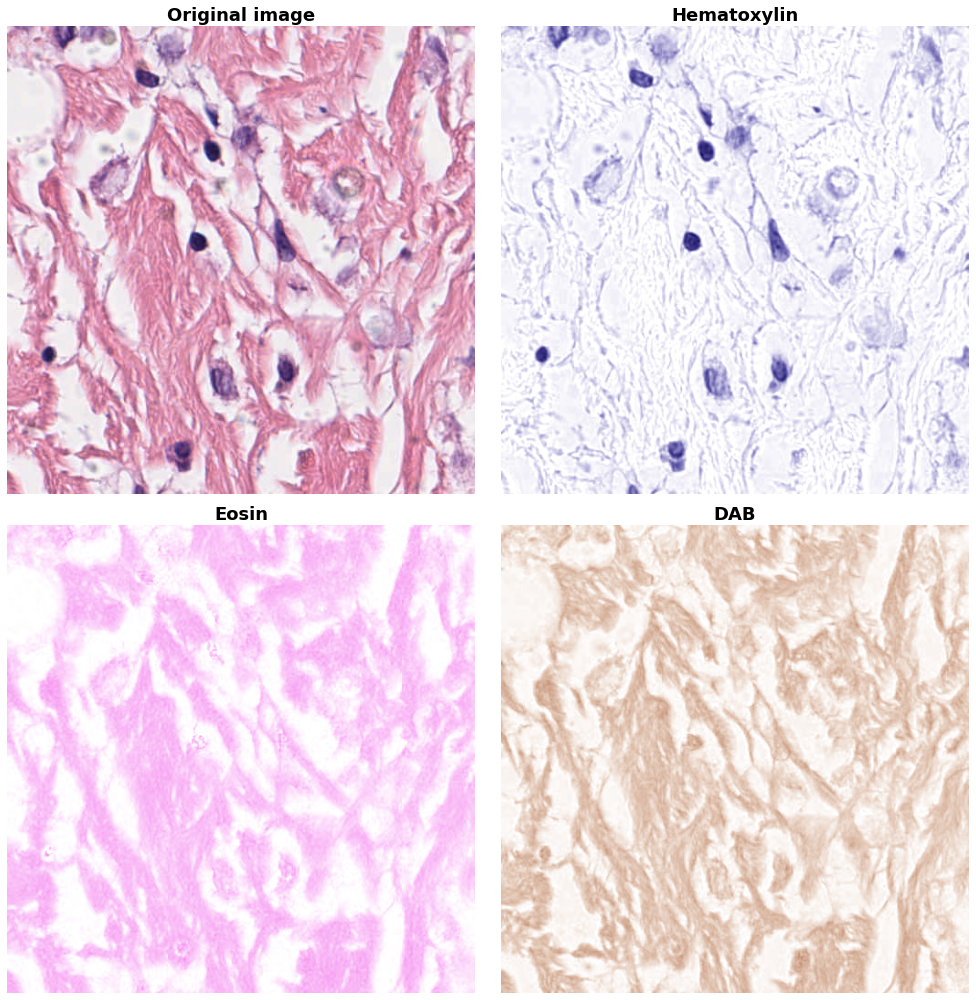

In [8]:
# The following code is modified from https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py
#
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cucim.skimage import color

#transfer our array to the device
ihc_rgb = cp.asarray(region)

# transform to colorspace where the stains are separated
ihc_hed = color.rgb2hed(ihc_rgb)

# Create an RGB image for visualizing each of the stains
null = cp.zeros_like(ihc_hed[:, :, 0])
ihc_h = color.hed2rgb(cp.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = color.hed2rgb(cp.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = color.hed2rgb(cp.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Transfer each color image back to the CPU prior to visualization
ihc_h, ihc_e, ihc_d = map(cp.asnumpy, [ihc_h, ihc_e, ihc_d])

fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
fontdict = dict(fontsize=18, fontweight='bold')

ax = axes.ravel()
ax[0].imshow(cp.asnumpy(ihc_rgb))
ax[0].set_title("Original image", fontdict=fontdict)
ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin", fontdict=fontdict)
ax[2].imshow(ihc_e)
ax[2].set_title("Eosin", fontdict=fontdict)
ax[3].imshow(ihc_d)
ax[3].set_title("DAB", fontdict=fontdict)
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

plt.show()

## Applying Albumentation

[Albumentation](https://albumentations.ai/) is a popular library for image augmentation in DeepLearning. It has [transforms interface](https://albumentations.ai/docs/api_reference/core/transforms_interface/) that we can add additional operations.

Many operations in Albumentation inherits [DualTransform](https://albumentations.ai/docs/api_reference/core/transforms_interface/#albumentations.core.transforms_interface.DualTransform) interface, but here we provide an example of using [ImageOnlyTransform](https://albumentations.ai/docs/api_reference/core/transforms_interface/#albumentations.core.transforms_interface.ImageOnlyTransform) interface with [Compose](https://albumentations.ai/docs/api_reference/core/composition/#albumentations.core.composition.Compose)

The example uses scikit-image's [resize](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize) API.

Since its output data type is float64, we need to use [img_as_ubyte](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.img_as_ubyte) utility method to convert back to 8-bit RGB image.


In [9]:
try:
    import albumentations
except ImportError:
    raise ImportError("This example requires albumentations.")

float64
uint8


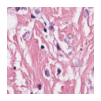

In [10]:
from cucim.skimage.transform import resize
from cucim.skimage.util import img_as_ubyte
import cupy as cp

resized_image = resize(cp.asarray(region),(128, 128))
# PIL.Image accepts only 8-bit image and resized_image has float64 data
# See https://scikit-image.org/docs/dev/user_guide/data_types.html#input-types
print(resized_image.dtype)
# Convert to 8-bit image
resized_image = img_as_ubyte(resized_image)
print(resized_image.dtype)

#Image.fromarray(resized_image.get()) 
visualize(resized_image.get())

### Reading and Resize Image with Albumentation's Compose method

We can define `Resize` operation that inherits `ImageOnlyTransform` class.

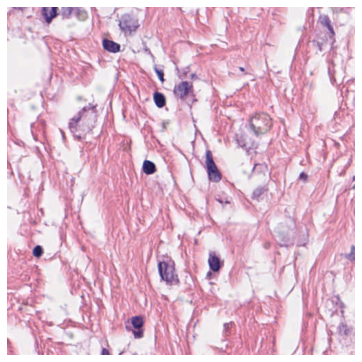

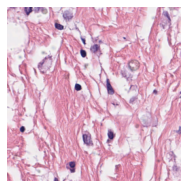

In [11]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

from albumentations import Compose
from albumentations.core.transforms_interface import ImageOnlyTransform
from cucim import CuImage
from cucim.skimage.transform import resize
from cucim.skimage.util import img_as_ubyte
import numpy as np
import cupy as cp

def visualize(image):
    dpi = 80.0
    height, width, _ = image.shape
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.axis('off')
    plt.imshow(image)

class Resize(ImageOnlyTransform):
    def __init__(self, height, width, order=None, mode='reflect', cval=0, clip=True, preserve_range=False, anti_aliasing=None,
                 anti_aliasing_sigma=None, **params):
        super().__init__(self)
        self.height = height
        self.width = width
#         self.order = order
#         self.mode = mode
#         self.cval = cval
#         self.clip = clip
#         self.preserve_range = preserve_range
#         self.anti_aliasing = anti_aliasing

    def apply(self, img, **params):
        # Note: output_shape argument is (height, width)
        resized_image = img_as_ubyte(resize(cp.asarray(region), (256, 256))).get() 
        return resized_image

img = CuImage(INPUT_PATH)
image = np.asarray(img.read_region((50000, 40000), (512, 512)))

visualize(image)

transform = Compose([
    # Note: input argument is (height, width), not (width, height)
    Resize(256, 256), 
])

augmented_image = transform(image=image)['image']

visualize(augmented_image)


In this example, to adapt Albumentation, we convert numpy array to Cupy array and copy back to numpy array after processing.

In practice, it is better to avoid copying back to CPU memory so better to combining GPU operations in a single transform operator.